In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import time
import json
import argparse
import numpy as np
import cv2
import torch
import tensorflow as tf
from tensorflow.python.framework import graph_util
from easydict import EasyDict as edict
from yaml import load

import sys
sys.path.append('../data/')
sys.path.append('../model/')

from datasets import Human
from data_aug import Normalize_Img, Anti_Normalize_Img

from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt
import pylab
% matplotlib inline
plt.rcParams['figure.figsize'] = (5,5)

In [2]:
def resize_padding(image, dstshape, padValue=0):
    height, width, _ = image.shape
    ratio = float(width)/height # ratio = (width:height)
    dst_width = int(min(dstshape[1]*ratio, dstshape[0]))
    dst_height = int(min(dstshape[0]/ratio, dstshape[1]))
    origin = [int((dstshape[1] - dst_height)/2), int((dstshape[0] - dst_width)/2)]
    if len(image.shape)==3:
        image_resize = cv2.resize(image, (dst_width, dst_height))
        newimage = np.zeros(shape = (dstshape[1], dstshape[0], image.shape[2]), dtype = np.uint8) + padValue
        newimage[origin[0]:origin[0]+dst_height, origin[1]:origin[1]+dst_width, :] = image_resize
        bbx = [origin[1], origin[0], origin[1]+dst_width, origin[0]+dst_height] # x1,y1,x2,y2
    else:
        image_resize = cv2.resize(image, (dst_width, dst_height),  interpolation = cv2.INTER_NEAREST)
        newimage = np.zeros(shape = (dstshape[1], dstshape[0]), dtype = np.uint8)
        newimage[origin[0]:origin[0]+height, origin[1]:origin[1]+width] = image_resize
        bbx = [origin[1], origin[0], origin[1]+dst_width, origin[0]+dst_height] # x1,y1,x2,y2
    return newimage, bbx

def generate_input(exp_args, inputs, prior=None):
    inputs_norm = Normalize_Img(inputs, scale=exp_args.img_scale, mean=exp_args.img_mean, val=exp_args.img_val)
    
    if exp_args.video == True:
        if prior is None:
            prior = np.zeros((exp_args.input_height, exp_args.input_width, 1))
            inputs_norm = np.c_[inputs_norm, prior]
        else:
            prior = prior.reshape(exp_args.input_height, exp_args.input_width, 1)
            inputs_norm = np.c_[inputs_norm, prior]
       
    inputs = np.transpose(inputs_norm, (2, 0, 1))
    return np.array(inputs, dtype=np.float32)

def pred_single(model, exp_args, img_ori, prior=None):
    in_shape = img_ori.shape
#     img, bbx = resize_padding(img_ori, [exp_args.input_height, exp_args.input_width], padValue=exp_args.padding_color)
    image_resize = cv2.resize(img_ori, (224, 224))

#     in_ = generate_input(exp_args, img, prior)
    inputs_norm = Normalize_Img(image_resize, scale=exp_args.img_scale, mean=exp_args.img_mean, val=exp_args.img_val)
    in_ = inputs_norm[np.newaxis, :, :, :]
    
    with tf.Session() as sess:
        
        tf.global_variables_initializer().run()
        output_graph_def = tf.GraphDef()
        with open("../myTrain/Model/result.pb", "rb") as f:
            print("Loading pb")
            output_graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(output_graph_def, name="")
            
        graph = tf.get_default_graph()
        x = graph.get_tensor_by_name('Inputs/x_input:0')
        y = graph.get_tensor_by_name('result:0')
        img_out = sess.run(y, feed_dict={x:in_})
    
    predimg = img_out[0,:,:,1]
    out = predimg
    out = cv2.resize(out, (in_shape[1], in_shape[0]))
    return out, predimg

In [3]:
print ('===========> loading config <============')
config_path = '../config/model_mobilenetv2_without_auxiliary_losses.yaml'
print ("config path: ", config_path)
with open(config_path, 'rb') as f:
    cont = f.read()
cf = load(cont)

exp_args = edict()

exp_args.istrain = cf['istrain']  # set the mode
exp_args.task = cf['task']  # only support 'seg' now
exp_args.datasetlist = cf['datasetlist']
exp_args.model_root = cf['model_root']
exp_args.data_root = cf['data_root']
exp_args.file_root = cf['file_root']

# the height of input images, default=224
exp_args.input_height = cf['input_height']
# the width of input images, default=224
exp_args.input_width = cf['input_width']

# if exp_args.video=True, add prior channel for input images, default=False
exp_args.video = cf['video']
# the probability to set empty prior channel, default=0.5
exp_args.prior_prob = cf['prior_prob']

# whether to add boundary auxiliary loss, default=False
exp_args.addEdge = cf['addEdge']
# the weight of boundary auxiliary loss, default=0.1
exp_args.edgeRatio = cf['edgeRatio']
# whether to add consistency constraint loss, default=False
exp_args.stability = cf['stability']
# whether to use KL loss in consistency constraint loss, default=True
exp_args.use_kl = cf['use_kl']
# temperature in consistency constraint loss, default=1
exp_args.temperature = cf['temperature']
# the weight of consistency constraint loss, default=2
exp_args.alpha = cf['alpha']

# input normalization parameters
exp_args.padding_color = cf['padding_color']
exp_args.img_scale = cf['img_scale']
# BGR order, image mean, default=[103.94, 116.78, 123.68]
exp_args.img_mean = cf['img_mean']
# BGR order, image val, default=[1/0.017, 1/0.017, 1/0.017]
exp_args.img_val = cf['img_val']

# whether to use pretian model to init portraitnet
exp_args.init = cf['init']
# whether to continue training
exp_args.resume = cf['resume']

# if exp_args.useUpsample==True, use nn.Upsample in decoder, else use nn.ConvTranspose2d
exp_args.useUpsample = cf['useUpsample']
# if exp_args.useDeconvGroup==True, set groups=input_channel in nn.ConvTranspose2d
exp_args.useDeconvGroup = cf['useDeconvGroup']

# img_ori = cv2.imread("/home/yupeng/Program/python/Data/EG1800/Images/00457.png")

import model_mobilenetv2_seg_small_tf as modellib
netmodel = modellib.MobileNetV2(n_class=2,
                                addEdge=exp_args.addEdge,
                                channelRatio=1.0,
                                minChannel=16)
print ("finish load PortraitNet ...")

===========> loading config <============
('config path: ', '../config/model_mobilenetv2_without_auxiliary_losses.yaml')
finish load PortraitNet ...


/home/yupeng/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Loading pb
(800, 600)


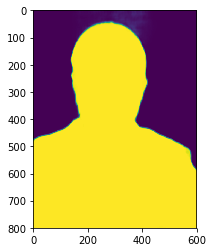

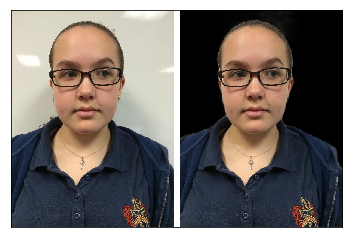

True

In [4]:
img_ori = cv2.imread("../../Data/EG1800/Images/00300.png") # 00001- 02632

background = np.zeros_like(img_ori)

prior = None
height, width, _ = img_ori.shape

alphargb, pred = pred_single(netmodel, exp_args, img_ori, prior)

print(alphargb.shape)

plt.imshow(alphargb)
plt.show()

alphargb = cv2.cvtColor(alphargb, cv2.COLOR_GRAY2BGR)
result = np.uint8(img_ori * alphargb + background * (1-alphargb))


myImg = np.ones((height, width*2 + 20, 3)) * 255
myImg[:, :width, :] = img_ori
myImg[:, width+20:, :] = result

plt.imshow(myImg[:,:,::-1]/255)
plt.yticks([])
plt.xticks([])
plt.show()
cv2.imwrite("result.jpg", result)